# 1.bis. CBoW demo (Full text)

### Imports

In [1]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import functools
import matplotlib.pyplot as plt
CUDA = torch.cuda.is_available()

### Step 1. Produce some data based on a given text for training our CBoW model    

In [2]:
def text_to_train(text, context_window):
    
    # Get data from list of words in text, using a context window of size k = context_window
    data = []
    for i in range(context_window, len(text) - context_window):
        context = [text[i+e] for e in range(-context_window, context_window+1) if i+e != i]
        target = text[i]
        data.append((context, target))
        
    return data

In [3]:
def create_text():
    
    # Load corpus from file
    with open("./text.txt", 'r', encoding="utf8",) as f:
        corpus = f.readlines()
    f.close()
    
    # Join corpus into a single string
    text = ""
    for s in corpus:
        l = s.split()
        for s2 in l:
            # Removes all special characters from string
            s2 = ''.join(filter(str.isalnum, s2))
            s2 += ' '
            text += s2.lower()
    text = text.split()
    
    return text

In [4]:
text = create_text()
print(text)

['i', 'am', 'happy', 'to', 'join', 'with', 'you', 'today', 'in', 'what', 'will', 'go', 'down', 'in', 'history', 'as', 'the', 'greatest', 'demonstration', 'for', 'freedom', 'in', 'the', 'history', 'of', 'our', 'nation', 'five', 'score', 'years', 'ago', 'a', 'great', 'american', 'in', 'whose', 'symbolic', 'shadow', 'we', 'stand', 'today', 'signed', 'the', 'emancipation', 'proclamation', 'this', 'momentous', 'decree', 'came', 'as', 'a', 'great', 'beacon', 'of', 'hope', 'to', 'millions', 'of', 'slaves', 'who', 'had', 'been', 'seared', 'in', 'the', 'flames', 'of', 'whithering', 'injustice', 'it', 'came', 'as', 'a', 'joyous', 'daybreak', 'to', 'end', 'the', 'long', 'night', 'of', 'their', 'captivity', 'but', 'one', 'hundred', 'years', 'later', 'the', 'colored', 'america', 'is', 'still', 'not', 'free', 'one', 'hundred', 'years', 'later', 'the', 'life', 'of', 'the', 'colored', 'american', 'is', 'still', 'sadly', 'crippled', 'by', 'the', 'manacle', 'of', 'segregation', 'and', 'the', 'chains', '

In [5]:
def generate_data(text, context_window):
    
    # Create vocabulary set V
    vocab = set(text)
    
    # Word to index and index 2 word converters
    word2index = {w:i for i,w in enumerate(vocab)}
    index2word = {i:w for i,w in enumerate(vocab)}
    
    # Generate data
    data = text_to_train(text, context_window)
    
    return vocab, data, word2index, index2word

In [6]:
vocab, data, word2index, index2word = generate_data(text, context_window = 2)

In [7]:
print(vocab)

{'fierce', 'boys', 'transformed', 'captivity', 'wrote', 'note', 'if', 'constitution', 'all', 'their', 'faith', 'insufficient', 'am', 'nineteen', 'meaning', 'our', 'lips', 'whithering', 'georgia', 'tranquility', 'friends', 'created', 'ring', 'one', 'still', 'continue', 'old', 'true', 'cash', 'brothers', 'highways', 'which', 'sweet', 'satisfied', 'time', 'also', 'veterans', 'blow', 'catholics', 'check', 'whose', 'insofar', 'god', 'hotels', 'shall', 'had', 'so', 'citizenship', 'cities', 'thank', 'rise', 'despair', 'beacon', 'promise', 'even', 'corners', 'slopes', 'exalted', 'mississippi', 'cannot', 'deeply', 'ghetto', 'come', 'left', 'whirlwinds', 'white', 'real', 'quicksand', 'bright', 'what', 'almighty', 'give', 'protestants', 'like', 'peoples', 'lives', 'low', 'quest', 'let', 'now', 'society', 'colored', 'crooked', 'republic', 'sit', 'well', 'lodging', 'gentiles', 'underestimate', 'moment', 'independence', 'pray', 'later', 'that', 'were', 'stripped', 'mountainside', 'discontent', 'its'

In [8]:
print(word2index)

{'fierce': 0, 'boys': 1, 'transformed': 2, 'captivity': 3, 'wrote': 4, 'note': 5, 'if': 6, 'constitution': 7, 'all': 8, 'their': 9, 'faith': 10, 'insufficient': 11, 'am': 12, 'nineteen': 13, 'meaning': 14, 'our': 15, 'lips': 16, 'whithering': 17, 'georgia': 18, 'tranquility': 19, 'friends': 20, 'created': 21, 'ring': 22, 'one': 23, 'still': 24, 'continue': 25, 'old': 26, 'true': 27, 'cash': 28, 'brothers': 29, 'highways': 30, 'which': 31, 'sweet': 32, 'satisfied': 33, 'time': 34, 'also': 35, 'veterans': 36, 'blow': 37, 'catholics': 38, 'check': 39, 'whose': 40, 'insofar': 41, 'god': 42, 'hotels': 43, 'shall': 44, 'had': 45, 'so': 46, 'citizenship': 47, 'cities': 48, 'thank': 49, 'rise': 50, 'despair': 51, 'beacon': 52, 'promise': 53, 'even': 54, 'corners': 55, 'slopes': 56, 'exalted': 57, 'mississippi': 58, 'cannot': 59, 'deeply': 60, 'ghetto': 61, 'come': 62, 'left': 63, 'whirlwinds': 64, 'white': 65, 'real': 66, 'quicksand': 67, 'bright': 68, 'what': 69, 'almighty': 70, 'give': 71, '

In [9]:
print(index2word)

{0: 'fierce', 1: 'boys', 2: 'transformed', 3: 'captivity', 4: 'wrote', 5: 'note', 6: 'if', 7: 'constitution', 8: 'all', 9: 'their', 10: 'faith', 11: 'insufficient', 12: 'am', 13: 'nineteen', 14: 'meaning', 15: 'our', 16: 'lips', 17: 'whithering', 18: 'georgia', 19: 'tranquility', 20: 'friends', 21: 'created', 22: 'ring', 23: 'one', 24: 'still', 25: 'continue', 26: 'old', 27: 'true', 28: 'cash', 29: 'brothers', 30: 'highways', 31: 'which', 32: 'sweet', 33: 'satisfied', 34: 'time', 35: 'also', 36: 'veterans', 37: 'blow', 38: 'catholics', 39: 'check', 40: 'whose', 41: 'insofar', 42: 'god', 43: 'hotels', 44: 'shall', 45: 'had', 46: 'so', 47: 'citizenship', 48: 'cities', 49: 'thank', 50: 'rise', 51: 'despair', 52: 'beacon', 53: 'promise', 54: 'even', 55: 'corners', 56: 'slopes', 57: 'exalted', 58: 'mississippi', 59: 'cannot', 60: 'deeply', 61: 'ghetto', 62: 'come', 63: 'left', 64: 'whirlwinds', 65: 'white', 66: 'real', 67: 'quicksand', 68: 'bright', 69: 'what', 70: 'almighty', 71: 'give', 7

In [10]:
print(data)

[(['i', 'am', 'to', 'join'], 'happy'), (['am', 'happy', 'join', 'with'], 'to'), (['happy', 'to', 'with', 'you'], 'join'), (['to', 'join', 'you', 'today'], 'with'), (['join', 'with', 'today', 'in'], 'you'), (['with', 'you', 'in', 'what'], 'today'), (['you', 'today', 'what', 'will'], 'in'), (['today', 'in', 'will', 'go'], 'what'), (['in', 'what', 'go', 'down'], 'will'), (['what', 'will', 'down', 'in'], 'go'), (['will', 'go', 'in', 'history'], 'down'), (['go', 'down', 'history', 'as'], 'in'), (['down', 'in', 'as', 'the'], 'history'), (['in', 'history', 'the', 'greatest'], 'as'), (['history', 'as', 'greatest', 'demonstration'], 'the'), (['as', 'the', 'demonstration', 'for'], 'greatest'), (['the', 'greatest', 'for', 'freedom'], 'demonstration'), (['greatest', 'demonstration', 'freedom', 'in'], 'for'), (['demonstration', 'for', 'in', 'the'], 'freedom'), (['for', 'freedom', 'the', 'history'], 'in'), (['freedom', 'in', 'history', 'of'], 'the'), (['in', 'the', 'of', 'our'], 'history'), (['the',

In [11]:
def words_to_tensor(words: list, w2i: dict, dtype = torch.FloatTensor):
    tensor =  dtype([w2i[word] for word in words])
    tensor = tensor.cuda()
    return Variable(tensor)

### Step 2. Create a CBoW model and train

In [12]:
class CBOW(nn.Module):

    def __init__(self, context_size, embedding_size, vocab_size):
        super(CBOW, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_size)
        self.linear = nn.Linear(embedding_size, vocab_size)

    def forward(self, inputs):
        lookup_embeds = self.embeddings(inputs)
        embeds = lookup_embeds.sum(dim=0)
        out = self.linear(embeds)
        #out = F.log_softmax(out, dim = -1)
        return out

In [13]:
# Create model and pass to CUDA
model = CBOW(context_size = 2, embedding_size = 20, vocab_size = len(vocab))
model = model.cuda()
model.train()

CBOW(
  (embeddings): Embedding(467, 20)
  (linear): Linear(in_features=20, out_features=467, bias=True)
)

In [14]:
# Define training parameters
learning_rate = 0.001
epochs = 1000
torch.manual_seed(28)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

In [15]:
def get_prediction(context, model, word2index, index2word):
    
    # Get into eval() mode
    model.eval()
    ids = words_to_tensor(context, word2index, dtype = torch.LongTensor)
    
    # Forward pass
    prediction = model(ids)
    # Reshape to cover for absence of minibatches (needed for loss function)
    prediction = torch.reshape(prediction, (1, 467))
    _, index = torch.max(prediction, 1)
    
    return index2word[index.item()]

In [16]:
def check_accuracy(model, data, word2index, index2word):
    
    # Compute accuracy
    correct = 0
    for context, target in data:
        prediction = get_prediction(context, model, word2index, index2word)
        if prediction == target:
            correct += 1
            
    return correct/len(data)

In [17]:
losses = []
accuracies = []

for epoch in range(epochs):
    total_loss = 0
    
    for context, target in data:
        
        # Prepare data
        ids = words_to_tensor(context, word2index, dtype = torch.LongTensor)
        target = words_to_tensor([target], word2index, dtype = torch.LongTensor)
        
        # Forward pass
        model.zero_grad()
        output = model(ids)
        # Reshape to cover for absence of minibatches (needed for loss function)
        output = torch.reshape(output, (1, 467))
        loss = loss_func(output, target)
        
        # Backward pass and optim
        loss.backward()
        optimizer.step()
        
        # Loss update
        total_loss += loss.data.item()
    
    # Display
    if epoch % 10 == 0:
        accuracy = check_accuracy(model, data, word2index, index2word)
        print("Accuracy after epoch {} is {}".format(epoch, accuracy))
        accuracies.append(accuracy)
        losses.append(total_loss)

Accuracy after epoch 0 is 0.011387900355871887
Accuracy after epoch 10 is 0.15800711743772242
Accuracy after epoch 20 is 0.20498220640569395
Accuracy after epoch 30 is 0.2398576512455516
Accuracy after epoch 40 is 0.2683274021352313
Accuracy after epoch 50 is 0.29252669039145907
Accuracy after epoch 60 is 0.3217081850533808
Accuracy after epoch 70 is 0.3423487544483986
Accuracy after epoch 80 is 0.36512455516014236
Accuracy after epoch 90 is 0.3921708185053381
Accuracy after epoch 100 is 0.42562277580071173
Accuracy after epoch 110 is 0.4604982206405694
Accuracy after epoch 120 is 0.49395017793594304
Accuracy after epoch 130 is 0.5209964412811388
Accuracy after epoch 140 is 0.5466192170818506
Accuracy after epoch 150 is 0.5750889679715302
Accuracy after epoch 160 is 0.5886120996441281
Accuracy after epoch 170 is 0.602135231316726
Accuracy after epoch 180 is 0.6199288256227758
Accuracy after epoch 190 is 0.6291814946619217
Accuracy after epoch 200 is 0.6462633451957296
Accuracy after ep

### 3. Visualization

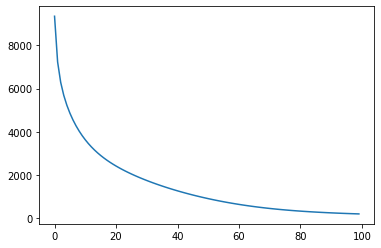

In [18]:
# Display losses over time
plt.figure()
plt.plot(losses)
plt.show()

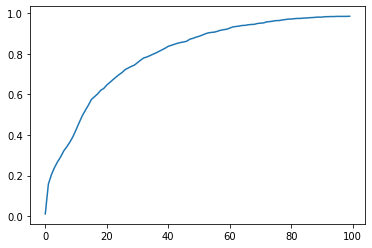

In [19]:
# Display accuracy over time
plt.figure()
plt.plot(accuracies)
plt.show()

In [26]:
word1 = words_to_tensor(["boys"], word2index, dtype = torch.LongTensor)
word2 = words_to_tensor(["brothers"], word2index, dtype = torch.LongTensor)
word3 = words_to_tensor(["dignity"], word2index, dtype = torch.LongTensor)
w1 = torch.reshape(model.embeddings(word1), (20,))
w2 = torch.reshape(model.embeddings(word2), (20,))
w3 = torch.reshape(model.embeddings(word3), (20,))
print(w1)
print(w2)
print(w3)

# Boys and Brothers have a somewhat close semantic meaning (strong positive value)
print(torch.dot(w1, w2).item())
# Boys and Dignity do not have a close semantic meaning (strong neg value)
print(torch.dot(w1, w3).item())

tensor([-1.0168,  0.1350, -0.0646, -0.7214,  1.0488,  1.6698,  2.6366,  0.6398,
         0.7524,  0.4168,  0.9607, -0.5750, -0.1073,  0.4060,  0.0531,  1.4814,
        -0.0602,  1.0371, -0.0558,  1.1748], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([-0.7323,  0.0883,  0.7710,  0.3849,  0.2881,  1.1192, -0.2087,  1.4882,
        -2.7480, -1.1802,  1.1256,  1.3347, -0.5806, -0.2984,  1.4252,  0.8169,
         0.7852,  1.1973, -0.9058,  0.5082], device='cuda:0',
       grad_fn=<ViewBackward>)
tensor([ 0.6021,  0.1734,  0.6861,  0.0644, -0.8524,  1.7485, -1.3037,  0.5885,
         0.3394, -0.4285, -0.3983, -0.7047, -0.3383, -0.4225, -0.4539, -0.3475,
         0.5389, -0.9484,  2.0652, -1.3177], device='cuda:0',
       grad_fn=<ViewBackward>)
3.825289726257324
-4.968987464904785
